## Check that the RGI entitites can be attributed to the correct region and sub-region  

This is the second of a series of 3 similar notebooks. This one checks that the first problem has been resolved.

In [1]:
rgi_version = '60'
out_dir = 'RGI62_update_logs'
in_dir = 'RGI62'

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import geopandas as gpd
import shapely.geometry as shpg
import progressbar
import os
import numpy as np
from oggm import utils, cfg
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
in_dir = os.path.abspath(os.path.join(in_dir, '00_rgi62_regions'))
out_dir = os.path.abspath(out_dir)

In [5]:
# The RGI megafile
out = []
for reg in range(1, 20):
    sh = gpd.read_file(utils.get_rgi_region_file('{:02d}'.format(reg), version=rgi_version)).set_index('RGIId')
    out.append(sh)
mdf =  pd.concat(out)

In [6]:
# Add Point geometries for faster checks
mdf['points'] = [shpg.Point(lon, lat) for (lon, lat) in zip(mdf.CenLon, mdf.CenLat)]

In [7]:
rgi_reg = gpd.read_file(os.path.join(in_dir, '00_rgi62_O1Regions.shp'))
rgi_sreg = gpd.read_file(os.path.join(in_dir, '00_rgi62_O2Regions.shp'))

In [8]:
mdf['RGI_CODE'] = ['{:02d}-{:02d}'.format(int(d1), int(d2)) for (d1, d2) in zip(mdf.O1Region, mdf.O2Region)]

In [9]:
np.testing.assert_equal(mdf['O1Region'].unique(), rgi_reg['RGI_CODE'].unique())

In [10]:
mdf['NOT_IN_REG'] = False
mdf['NEW_REG'] = ''
for reg in mdf['O1Region'].unique():
    sel = rgi_reg[rgi_reg.RGI_CODE == reg]
    mdf_sel = mdf.loc[mdf.O1Region == reg]
    for rid, p, g in progressbar.progressbar(zip(mdf_sel.index, mdf_sel.points, mdf_sel.geometry), 
                                             max_value=len(mdf_sel), suffix= ' RGI Reg: ' + reg):
        if not np.sum(sel.contains(p)) > 0:
            if not np.sum(sel.intersects(g)) > 0:
                mdf.loc[rid, 'NOT_IN_REG'] = True
                
                cc = rgi_reg.loc[rgi_reg.contains(p)]
                if len(cc) == 0:
                    pass
                elif len(cc) == 1:
                    mdf.loc[rid, 'NEW_REG'] = cc.iloc[0].RGI_CODE

100% (27108 of 27108) |#######| Elapsed Time: 0:00:36 Time:  0:00:36 RGI Reg: 1
100% (18855 of 18855) |#######| Elapsed Time: 0:00:15 Time:  0:00:15 RGI Reg: 2
100% (4556 of 4556) |#########| Elapsed Time: 0:00:01 Time:  0:00:01 RGI Reg: 3
100% (7415 of 7415) |#########| Elapsed Time: 0:00:01 Time:  0:00:01 RGI Reg: 4
100% (20261 of 20261) |#######| Elapsed Time: 0:00:05 Time:  0:00:05 RGI Reg: 5
100% (568 of 568) |###########| Elapsed Time: 0:00:00 Time:  0:00:00 RGI Reg: 6
100% (1615 of 1615) |#########| Elapsed Time: 0:00:00 Time:  0:00:00 RGI Reg: 7
100% (3417 of 3417) |#########| Elapsed Time: 0:00:00 Time:  0:00:00 RGI Reg: 8
100% (1069 of 1069) |#########| Elapsed Time: 0:00:00 Time:  0:00:00 RGI Reg: 9
100% (5151 of 5151) |########| Elapsed Time: 0:00:01 Time:  0:00:01 RGI Reg: 10
100% (3927 of 3927) |########| Elapsed Time: 0:00:01 Time:  0:00:01 RGI Reg: 11
100% (1888 of 1888) |########| Elapsed Time: 0:00:00 Time:  0:00:00 RGI Reg: 12
100% (54429 of 54429) |######| Elapsed T

In [11]:
misplaced = mdf.loc[mdf.NOT_IN_REG & mdf.NEW_REG]
assert len(misplaced) == 0
not_ok = mdf.loc[mdf.NOT_IN_REG & (mdf.NEW_REG == '')]
assert len(not_ok) == 0

In [12]:
mdf['NOT_IN_SREG'] = False
mdf['NEW_SREG'] = ''
for sreg in mdf['RGI_CODE'].unique():
    sel = rgi_sreg[rgi_sreg.RGI_CODE == sreg]
    mdf_sel = mdf.loc[mdf.RGI_CODE == sreg]
    for rid, p, g in progressbar.progressbar(zip(mdf_sel.index, mdf_sel.points, mdf_sel.geometry), 
                                             max_value=len(mdf_sel), suffix= ' RGI SREG: ' + sreg):
        if not np.sum(sel.contains(p)) > 0:
            if not np.sum(sel.intersects(g)) > 0:
                mdf.loc[rid, 'NOT_IN_SREG'] = True
                
                cc = rgi_sreg.loc[rgi_sreg.contains(p)]
                if len(cc) == 0:
                    pass
                elif len(cc) == 1:
                    mdf.loc[rid, 'NEW_SREG'] = cc.iloc[0].RGI_CODE

100% (5780 of 5780) |####| Elapsed Time: 0:00:01 Time:  0:00:01 RGI SREG: 01-02
100% (10551 of 10551) |##| Elapsed Time: 0:00:09 Time:  0:00:09 RGI SREG: 01-06
100% (4258 of 4258) |####| Elapsed Time: 0:00:01 Time:  0:00:01 RGI SREG: 01-04
100% (616 of 616) |######| Elapsed Time: 0:00:00 Time:  0:00:00 RGI SREG: 01-01
100% (872 of 872) |######| Elapsed Time: 0:00:00 Time:  0:00:00 RGI SREG: 01-03
100% (5031 of 5031) |####| Elapsed Time: 0:00:01 Time:  0:00:01 RGI SREG: 01-05
100% (3202 of 3202) |####| Elapsed Time: 0:00:00 Time:  0:00:00 RGI SREG: 02-04
100% (7387 of 7387) |####| Elapsed Time: 0:00:02 Time:  0:00:02 RGI SREG: 02-02
100% (5064 of 5064) |####| Elapsed Time: 0:00:03 Time:  0:00:03 RGI SREG: 02-03
100% (1967 of 1967) |####| Elapsed Time: 0:00:00 Time:  0:00:00 RGI SREG: 02-05
100% (1235 of 1235) |####| Elapsed Time: 0:00:00 Time:  0:00:00 RGI SREG: 02-01
100% (880 of 880) |######| Elapsed Time: 0:00:00 Time:  0:00:00 RGI SREG: 03-03
100% (627 of 627) |######| Elapsed Time:

In [13]:
misplaced = mdf.loc[mdf.NOT_IN_SREG & mdf.NEW_SREG]
print(len(misplaced))
not_ok = mdf.loc[mdf.NOT_IN_SREG & (mdf.NEW_SREG == '')]
assert len(not_ok) == 0

140


In [14]:
tw = misplaced.copy().drop(['points', 'NOT_IN_REG', 'NOT_IN_SREG'], axis=1).reset_index(level=0)
odir = utils.mkdir(os.path.join(out_dir, 'entities_misplaced'))
tw.to_file(os.path.join(odir, 'subreg_misplaced_after_cor.shp'))

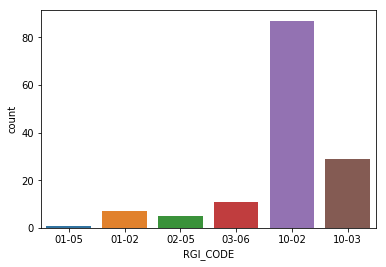

In [15]:
ax = sns.countplot(x="RGI_CODE", data=misplaced)

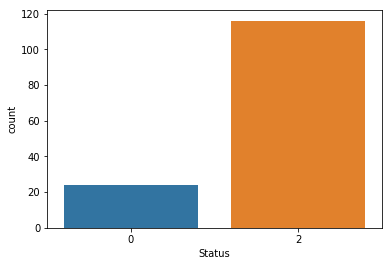

In [16]:
ax = sns.countplot(x="Status", data=misplaced)

In [17]:
print(np.sum(misplaced.Status == 2))

116
